In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from collections import defaultdict
import string
import os

USER_NAME = 'zj2244'
#USER_NAME = 'jzf02'

DATA_FRAME1 = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_linkedin_company\temp_datalab_records_linkedin_company.csv"
DATA_FRAME1 = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_linkedin_company.zip"
DATA_FRAME2 = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_job_listings\temp_datalab_records_job_listings.csv"
DATA_FRAME3 = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_social_facebook.zip"
#CSV_A = [r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_job_listings" + "_%d"%_k+".zip" for _k in range(1,7)]
CSV_A = [r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_job_listings" + " (%d)"%_k+".zip" for _k in range(1,8)]
CSV_B = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_linkedin_company.zip"
CSV_C = r"C:\Users"+"\\"+USER_NAME+r"\Downloads\temp_datalab_records_social_facebook.zip"


In [2]:
df2 = pd.read_csv(CSV_B)
#df1 = pd.read_csv(DATA_FRAME2)
#df3 = pd.read_csv(CSV_C)

C:\Users\zj2244\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def read_domains(domain_names, chunk=100000):
    df_list = []
    columns = ['domain', 'as_of_date', 'title', 'listing_id', 'posted_date', 'country']
    for filename in CSV_A:
        df_reader = pd.read_csv(filename, chunksize=chunk, infer_datetime_format=True, parse_dates=['as_of_date', 'posted_date'])
        count = 0
        for curr_df in df_reader:
            count += 1
            domains = set(curr_df['domain'])
            common = set()
            for domain in domains:
                matched = False
                for name in domain_names:
                    if name in domain:
                        matched = True
                        break
                if matched:
                    common.add(domain)
            df_list.append(curr_df[curr_df['domain'].isin(common)][columns].copy())
            if count % 10 == 0:
                print('Finished reading %d chunks of %s'%(count, filename))
    return pd.concat(df_list)
                
            
    

In [4]:
mask = (df2['as_of_date'] == df2['as_of_date'].max())& (df2['industry'].isin(['Pharmaceuticals', 'Biotechnology']))
df_bio = df2[mask].copy()
df_bio.sort_values(by='followers_count', inplace=True, ascending=False)

bio_companies = set(df2['company_name'][df2['industry'].isin(['Pharmaceuticals', 'Biotechnology'])])
bio_short = [_k.split()[0].lower() for _k in bio_companies]

domain_names = df_bio['website'].apply(lambda t: t.split('.')[-2].split('/')[-1] if type(t) == str else 'N/A')
curr_names = list(domain_names)[:10]
PICKLE_FILE = 'data_bio7.pkl'
if os.path.isfile(PICKLE_FILE):
    data = pd.read_pickle(PICKLE_FILE)
else:
    data = read_domains(curr_names)
    data.to_pickle(PICKLE_FILE)

In [5]:
grouped = data[['domain', 'as_of_date', 'title', 'listing_id', 'posted_date']].groupby('listing_id')
dur = grouped.min()
dur['Duration'] = grouped.max()['as_of_date'] - dur['as_of_date']


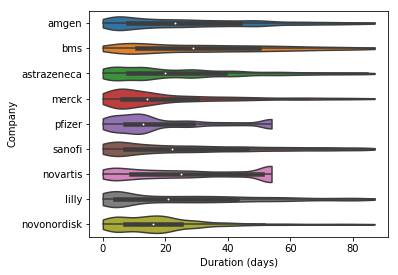

In [6]:
domain_map = defaultdict(str)
curr_names = domain_names[:10]

for domain in set(dur['domain']):
    for domain_name in curr_names:
        if domain_name in domain:
            domain_map[domain] = domain_name

dur['Days'] = dur['Duration'].apply(lambda t:t.days)
dur['Name'] = dur['domain'].apply(lambda t: domain_map[t] )
dur_1s = dur['Days'].mean() + 1*dur['Days'].std()
ax1 = sns.violinplot(data=dur[dur['Days']<dur_1s], x = 'Days', y='Name', cut=0)
ax1.set_ylabel('Company')
ax1.set_xlabel('Duration (days)')
#ax1.set_xlim(0, 80)
plt.tight_layout(rect=[0.06, 0.02, 1, 1])

plt.savefig('fig_posting_1.png', dpi=300)
plt.show()

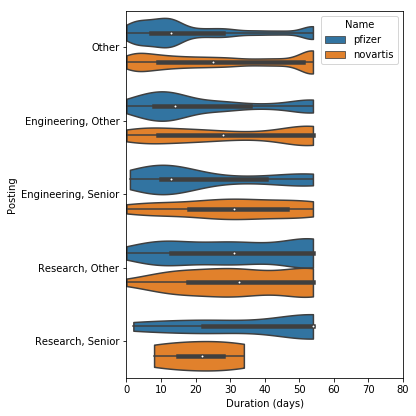

In [7]:
grouped = dur.groupby('title')
df_title = grouped.count().sort_values('domain', ascending=False)

m_research = dur['title'].str.contains('Research')
m_senior = (dur['title'].str.contains('Senior')) | (dur['title'].str.contains('Principle'))
m_engineering = dur['title'].str.contains('Eng')
dur['Type'] = 'Other'
dur.loc[m_research & m_senior,'Type'] = 'Research, Senior'
dur.loc[m_research & ~m_senior, 'Type'] = 'Research, Other'
dur.loc[m_engineering & m_senior, 'Type'] = 'Engineering, Senior'
dur.loc[m_engineering & ~m_senior, 'Type'] = 'Engineering, Other'

top_titles = (df_title.index[df_title.index.str.contains('Research')])
fig, ax0 = plt.subplots()
fig.set_size_inches(6, 6)
#ax1 = sns.violinplot(data=dur[dur['title'].isin(top_titles[:6])], x='Days', y='title', cut=0, ax=ax0)
ax1 = sns.violinplot(data=dur[dur['Name'].isin(curr_names[:2])], x='Days', y='Type',hue='Name', cut=0, ax=ax0)
ax1.set_ylabel('Posting')
ax1.set_xlabel('Duration (days)')
ax1.set_xlim(0, 80)
fig.tight_layout(rect=[0.02, 0.02, 1, 1])

plt.savefig('fig_posting_3.png', dpi=300)
plt.show()
